## 无监督异常检测
- 采用无监督学习查找办公环境温度的异常，因为没有标签，所以没有准备的分数，用可视化的方法检验异常检测的效果。

- 数据来源与Kaggle 网站上的流数据异常检测的数据集，流数据是有序的、时间戳的、单值度量的。: https://www.kaggle.com/boltzmannbrain/nab

- 异常检测的方法和类别介绍：https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/

- IoT用例和智能方法组合示例：https://journalofbigdata.springeropen.com/articles/10.1186/s40537-014-0011-y

In [57]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np


import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm 
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
plt.rcParams['figure.figsize'] = (10.0, 8.0) 


ModuleNotFoundError: No module named 'pyemma'

In [2]:

# 返回每个点之间的距离序列及其与最近质心的距离
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# t训练马尔可夫模型得到转移矩阵
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

## 1 数据
### 1.1 读取数据
数据来源于：https://www.kaggle.com/boltzmannbrain/nab In realKnownCause/ambient_temperature_system_failure.csv


In [3]:
df = pd.read_csv("data/ambient_temperature_system_failure.csv")

### 1.2 数据理解



In [4]:
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


In [5]:
### 检查时间戳类型和频率
df.head(10)

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
5,2013-07-04 05:00:00,70.060966
6,2013-07-04 06:00:00,69.279765
7,2013-07-04 07:00:00,69.369608
8,2013-07-04 08:00:00,69.166714
9,2013-07-04 09:00:00,68.986083


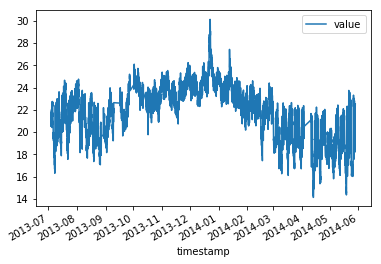

In [6]:
# 改变时间戳列的类型用于绘图
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 将华氏温度更改为°C（平均温度=71->华氏温度）
df['value'] = (df['value'] - 32) * 5/9

# 数据绘图
df.plot(x='timestamp', y='value')

## 1.3 特征工程
提取有用的特征

In [7]:
# 小时，白天或晚上 (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)


In [8]:
#一周中的某一天（星期一=0，星期日=6），是否是周末或工作日。
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)


#数据集异常总体的估计（对于多个算法是必需的）
outliers_fraction = 0.01

In [9]:
# 时间转换为int类型，方便绘图
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

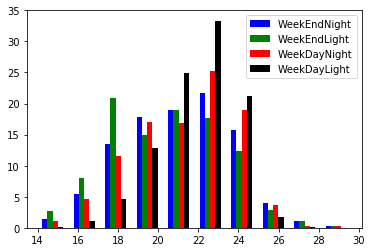

In [14]:
# # 创建4个似乎有用的不同类别（周末/工作日和夜晚/白天）
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

我们可以看到，在工作日的白天，温度更稳定。
# 2 模型
## 2.1 聚类
#### Use for collective anomalies (unordered). 

We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [15]:
# 选取有用特征并标准化
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# 缩减至两个有用的特征
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# 标准话两个新特征
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


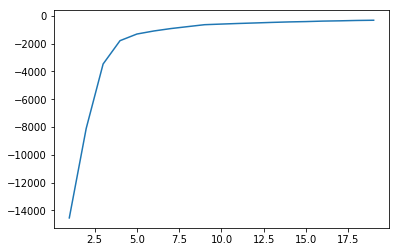

In [16]:
# 用不同的聚类中心数计算，以查看损失图（肘形法）
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [17]:
# 随意选择了15个聚类中心，并将这些数据添加到中央数据框中。
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0     712
5     649
8     627
10    617
3     596
7     579
4     537
12    425
1     405
14    397
6     354
9     352
2     343
11    338
13    336
Name: cluster, dtype: int64

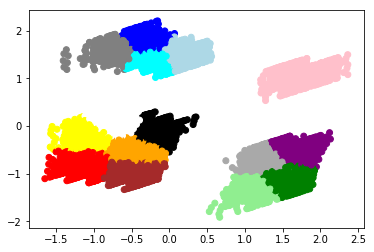

In [18]:
# 使用两个主要特征绘制聚类结果
plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [19]:
# 得到每个点与其最近质心之间的距离。最大距离被视为异常
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21包含方法2.1聚类的异常结果（0:正常，1:异常）
df['anomaly21'] = (distance >= threshold).astype(int)

/Users/lizhi/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


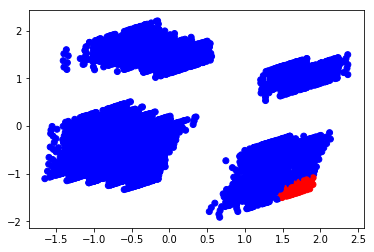

In [20]:
# 在聚类的试图中可视化异常检测结果，红色表示异常点
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

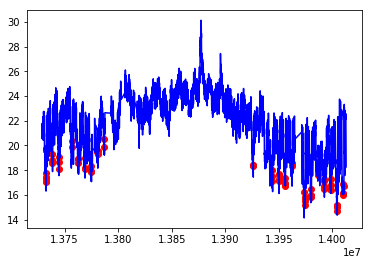

In [21]:
# 从时间维上画出检测得到的异常结果
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #异常

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

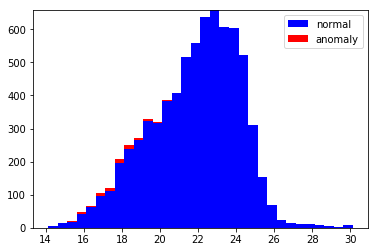

In [22]:
# 直方图可视化温度异常

a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

聚类异常检测方法检测到的异常分布于低温记录末端的低温异常值，它没有检测到高温异常的部分
## 2.2 分类+高斯 
#### 用于上下文数据和集体异常（无序）
我们将按（我们所想的）重要类别来划分数据。或者我们可以基于不同的集群分离数据（方法2.3）。然后我们独立地按类别找出异常值（高斯分布，单峰）。



In [24]:
# 根据先前定义的类别创建四个不同类别的数据
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

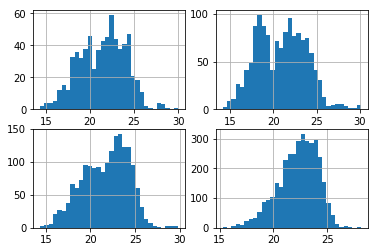

In [25]:
# 根据类别绘制数据的直方图分布
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [26]:
#  对每个类别应用基于高斯概率密度的异常检测 ellipticEnvelope(gaussian distribution) 
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)



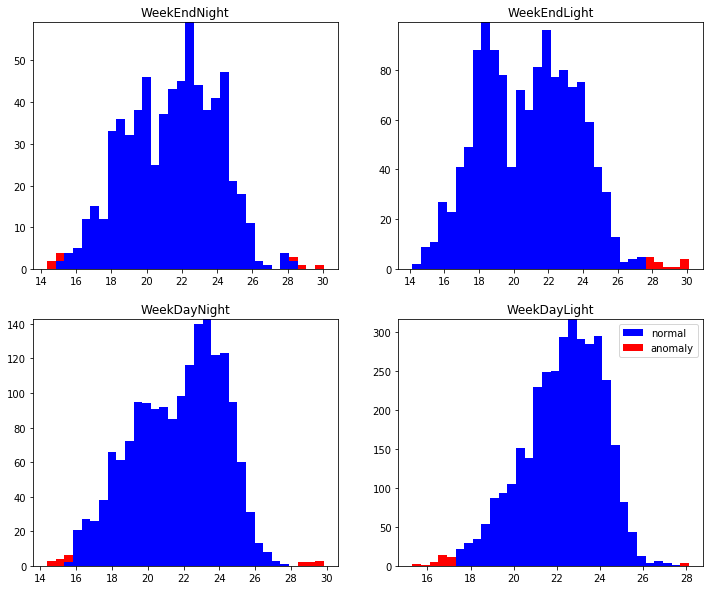

In [31]:
## 绘制每个类别异常检测的直方图分布图
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [32]:
# 合并数据
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

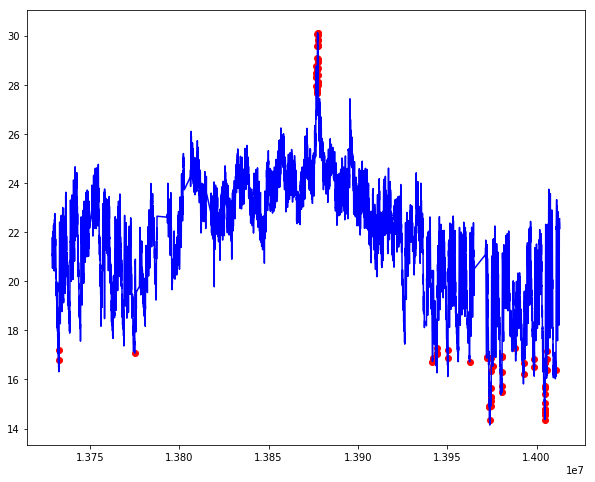

In [35]:
# 从时间维上绘制异常检测结果
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

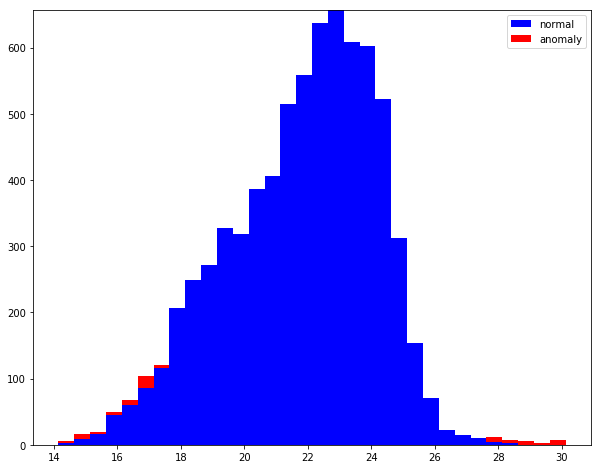

In [36]:
# 直方图可是化异常检测温度
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

良好的极端值检测和上下文分离增加了检测的精度。
## 2.3 聚类+高斯
与2.2 方法类似，但是使用聚类的方法数据分成不同的组类

## 2.4 Markov 链
#### 用于顺序异常（有序）
我们需要离散化数据点来定义马尔可夫链下的状态。我们只需要用“value”来定义本例子的状态，并定义5个级别的值（非常低、低、平均、高、非常高）/(VL, L, A, H, VH ).。
马尔可夫链将计算序列，如 ( VL, L, L, A, A, L, A ).的概率。如果概率很弱，我们将序列视为异常。··

In [43]:
# 定义不同的状态
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

# 获取数据集的异常标签， 评价状态为5个，概率小于20%

#df_anomaly =markovAnomaly(df_mm, 5, 0.20)
#df_anomaly = pd.Series(df_anomaly)
#print(df_anomaly.value_counts())

## 2.5 孤立森林
用于集体异常（无序）

简单，在不同的数据分布且高纬度数据中表现好

In [44]:
# 选择有用的特征，并标准化他们

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    7194
1      73
Name: anomaly25, dtype: int64


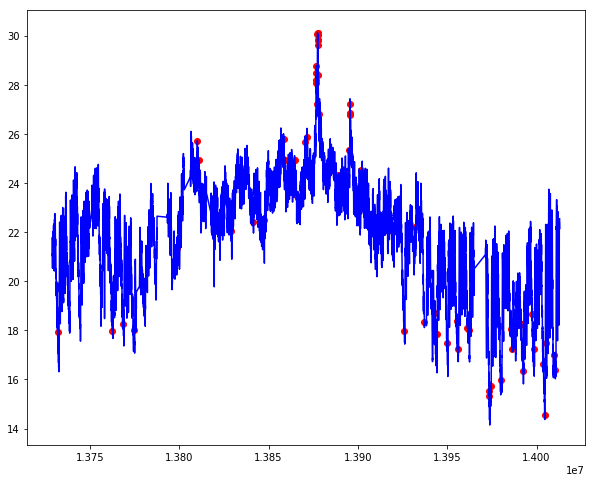

In [45]:
# 从时间维度上可视化异常检测结果
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

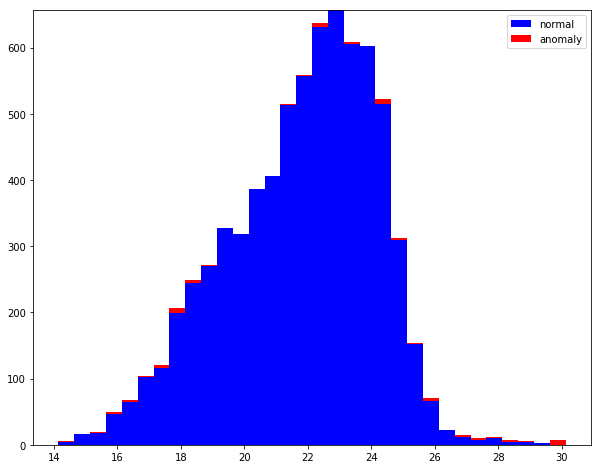

In [46]:
# 直方图可视化异常检测结果分布
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## 2.6 One class SVM
用于集体异常（无序）。
适合新的异常检测（训练数据无异常）。该算法对多模数据的处理效果好



In [47]:
# 选取有用的特征并标准化
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# 训练 one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
 
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


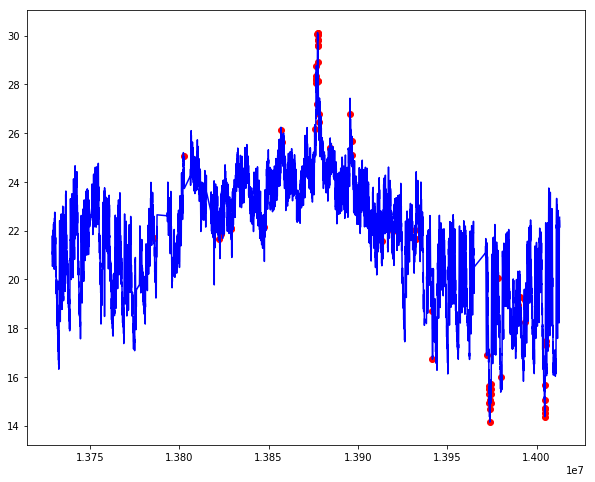

In [48]:
# 从时间维上可视化异常检测结果
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

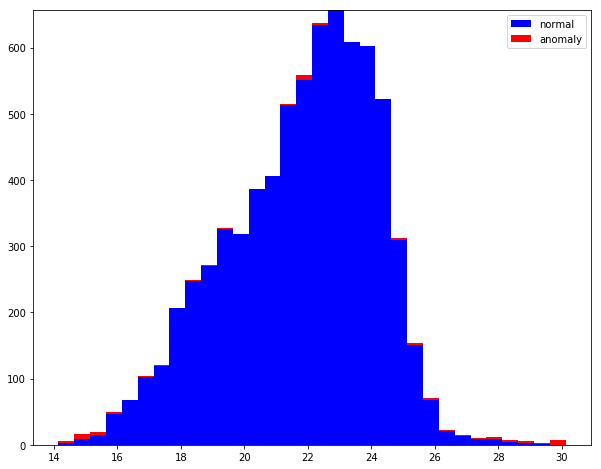

In [49]:
# 直方图可视化异常检测结果
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

给出了与孤立林相似的结果，但在平均值上发现了一些异常。很难知道它们是否相关。

## 2.7 RNN
用于顺序异常检测（有序）
RNN学习识别数据中的序列，然后根据之前的序列进行预测。当下一个数据点远离RNN预测时，我们则认为是异常。聚和、序列的大小和异常预测的大小是进行相关检测的重要参数。
这里我们使用前50个值进行学习，并且预测下一个值


In [50]:
#选择并标准话数据

data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# train/test大小参数
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#训练数据
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# 测试数据
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/lizhi/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/Users/lizhi/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/lizhi/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version

In [53]:
#为每个数据点创建前50个数据点的序列
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# 使数据集成为序列数据形状
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# 查看形状
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [54]:
#  RNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

Using TensorFlow backend.


In [55]:
# 创建模型
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

Instructions for updating:
Colocations handled automatically by placer.


/Users/lizhi/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/Users/lizhi/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 5), units=50)`
  import sys


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
compilation time : 0.06159710884094238


In [56]:
# 训练模型
#nb_epoch = 350

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=30,
    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.


/Users/lizhi/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 5548 samples, validate on 617 samples
Epoch 1/30
5548/5548 [==============================] - 14s 3ms/step - loss: 0.6538 - val_loss: 0.7772
Epoch 2/30
5548/5548 [==============================] - 10s 2ms/step - loss: 0.2264 - val_loss: 0.4826
Epoch 3/30
5548/5548 [==============================] - 10s 2ms/step - loss: 0.1822 - val_loss: 0.2731
Epoch 4/30
5548/5548 [==============================] - 10s 2ms/step - loss: 0.1256 - val_loss: 0.2459
Epoch 5/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.1099 - val_loss: 0.2352
Epoch 6/30
5548/5548 [==============================] - 8s 2ms/step - loss: 0.1044 - val_loss: 0.2315
Epoch 7/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.1076 - val_loss: 0.2183
Epoch 8/30
5548/5548 [==============================] - 9s 2ms/step - loss: 0.0987 - val_loss: 0.2063
Epoch 9/30
5548/5548 [==============================] - 8s 1ms/step - loss: 0.0922 - val_loss: 0.1966
Epoch 10/30
5548/5548 [========

In [59]:
# 保存模型，因为训练模型大概需要半个小时，我们并不想每次都训练

model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
#model.save_weights("model2.h5")
#print("Saved model to disk")


In [61]:
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

In [66]:


loaded_model = model 
diff=[]
ratio=[]
p = loaded_model.predict(x_test)

for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

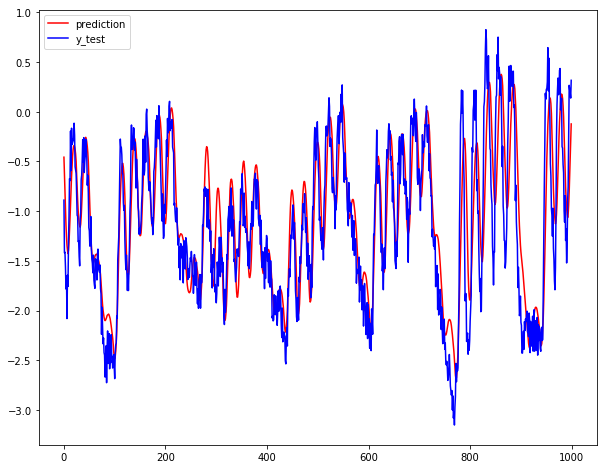

In [67]:
# 绘制预测结果跟实际值的比较
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [68]:
# 选择距离最大的值作为异常值

diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

#测试集中异常值的数据
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


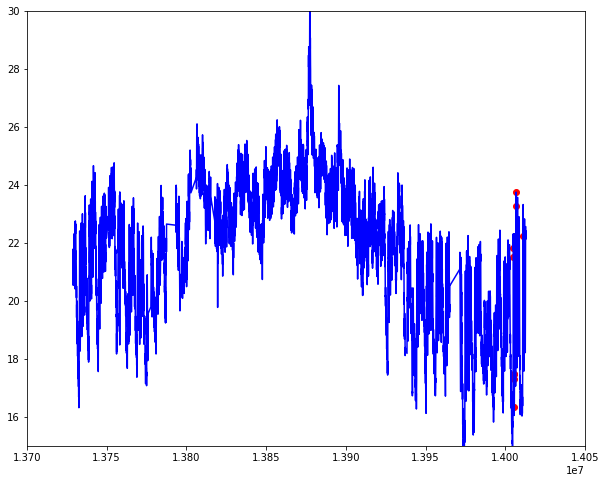

In [69]:
#从时间维度上可视化异常检测结果
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

No handles with labels found to put in legend.


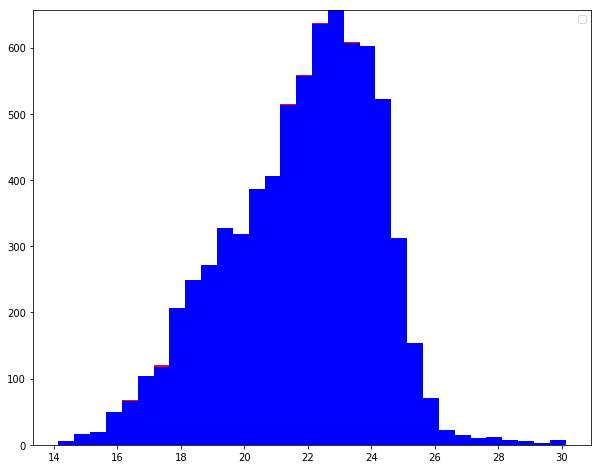

In [70]:
# 直方图可视化异常检测结果
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## 2.8 集体和顺序异常（有序）
这一类是最普通的，考虑排序和值组合。我们通常使用聚类+马尔可夫模型等算法的组合。

# 3 结论
对于本案例情况，上下文异常检测（categories+elliptique envelope）似乎是一个很好的解决方案。